#### 1. Data Processing

In [9]:
# Import the data from the website directly: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
import pandas as pd
adult_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None, skipinitialspace=True)

In [10]:
# Add header for each column
adult_df.columns = ["Age", "Workclass", "Fnlwgt", "Education","Education-num","Marital-status","Occupation","Relationship","Race","Sex","Capital-gain","Capital-loss","Hours-Per-Week","Native-country","salary"]

In [11]:
#  Check dataframe shape
adult_df.shape

(32561, 15)

In [12]:
# Drop the 3rd column from the data
adult_df.drop(columns=['Fnlwgt'],inplace=True)

In [13]:
# Use the .replace() method to make the following changes to the "salary" column:
adult_df['salary'].replace("<=50K",0,inplace=True)
adult_df['salary'].replace(">50K",1,inplace=True)

In [14]:
# g) Create your X dataframe (just your predictors). It should include every feature except for the target variable which is "salary".
X=adult_df.drop(columns=['salary'])
y=adult_df[['salary']]

In [15]:
X.shape

(32561, 13)

In [16]:
y.shape

(32561, 1)

In [17]:
# One-hot encoding
X_encoded = pd.get_dummies(X)
X_encoded.shape

(32561, 107)

In [18]:
#Split data into train / test set using an 70/30 split.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 101)

#### 2. Random Forest Classifier - Base Model:

In [72]:
# a) Use the RandomForestClassifier in sklearn. Fit your model on the training data.
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_train, y_train)

/Users/yangxiang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [73]:
# b) Use the fitted model to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.
y_pred_rf = rnd_clf.predict(X_test)
y_pred_proba_rf=rnd_clf.predict_proba(X_test)

In [76]:
# c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_rf)

array([[6835,  601],
       [ 871, 1462]])

In [77]:
# Build the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      7436
           1       0.71      0.63      0.67      2333

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.85      9769



In [79]:
# d) Calculate the AUC score (we did this in HW #4 many times).
from sklearn.metrics import roc_auc_score
# calculate roc_auc_score
roc_auc_score(y_test, y_pred_proba_rf[:,1])

0.8934059856856521

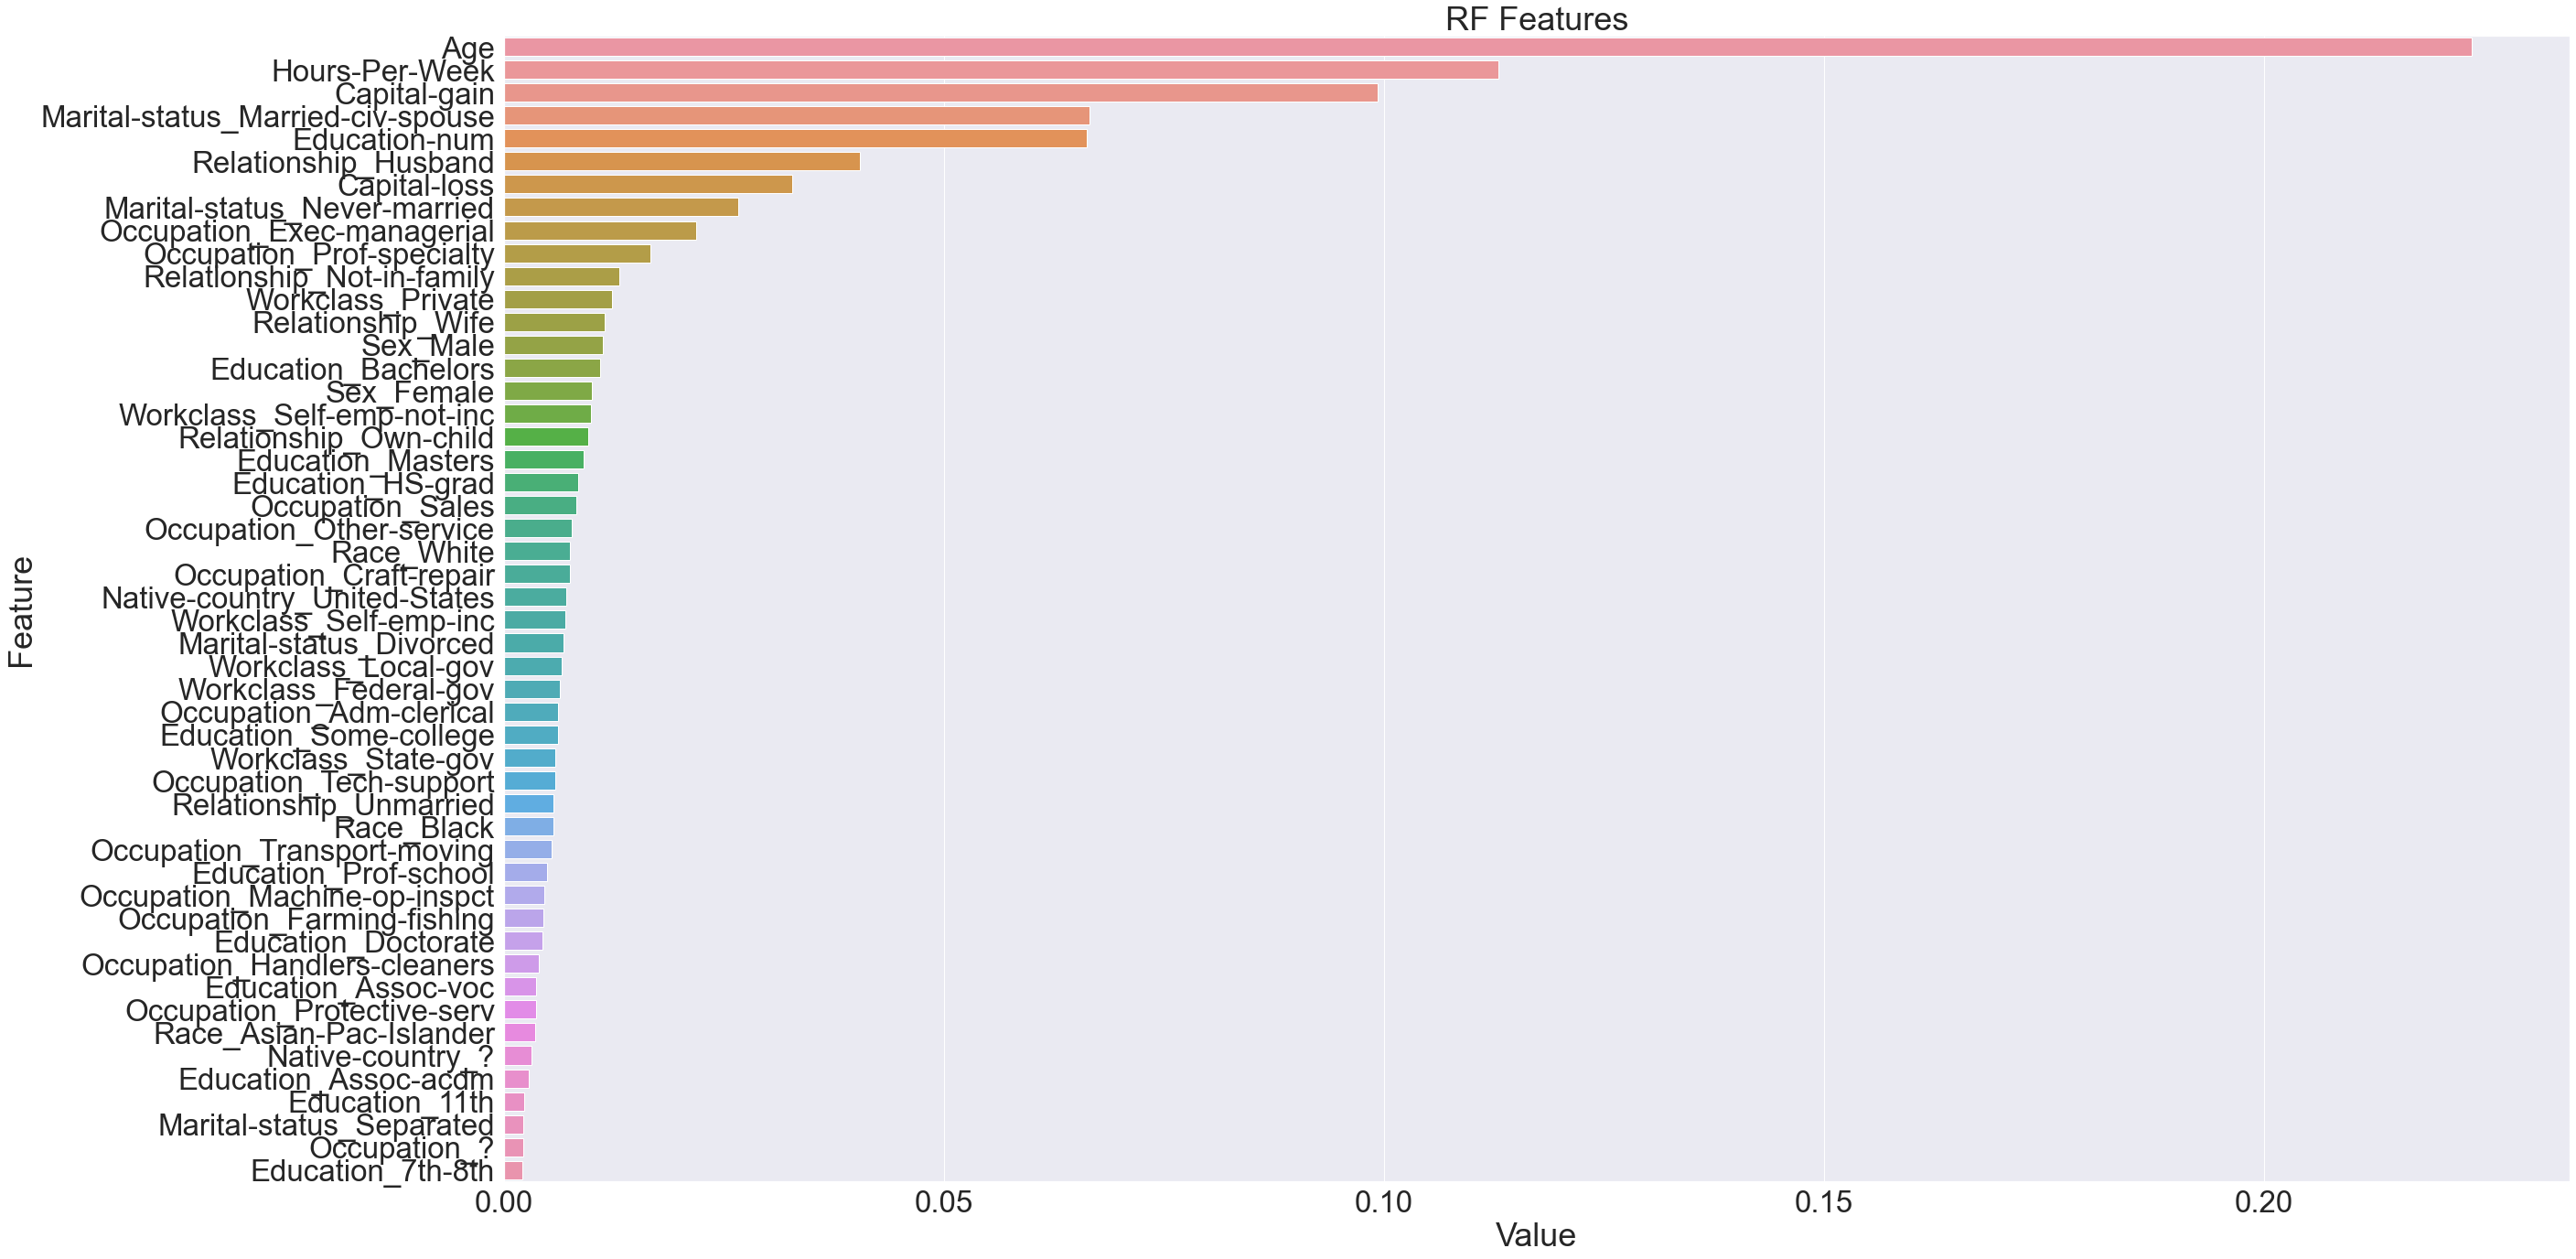

In [81]:
# e) Identify the top 5 features. Feel free to print a list OR to make a plot.
import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame({'Value':rnd_clf.feature_importances_,'Feature':X_train.columns})
plt.figure(figsize=(40, 20))
sns.set(font_scale = 3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:50])
plt.title('RF Features')
plt.tight_layout()
plt.show()

# The top 5 features are Age,hours per week,Capital-gain,Marital-status_married-civ-spouse,Education-num

In [82]:
#f) Using the model from part B, predict for the train data. 
y_pred_rf_train = rnd_clf.predict(X_train)
y_pred_proba_rf_train =rnd_clf.predict_proba(X_train)

In [83]:
# Build the confusion matrix
confusion_matrix(y_train, y_pred_rf_train)

array([[17124,   160],
       [  296,  5212]])

In [84]:
# Build the classification report
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_rf_train))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17284
           1       0.97      0.95      0.96      5508

    accuracy                           0.98     22792
   macro avg       0.98      0.97      0.97     22792
weighted avg       0.98      0.98      0.98     22792



In [85]:
# Calculate the roc_auc_score for this model on training data.
roc_auc_score(y_train, y_pred_proba_rf_train[:,1])

0.9978324221594661

###### Look at the classification report for the train data - is there overfitting for the RandomForest model happening?
The Model is showing a sign of overfitting since the accuracy between training data and testing data are huge. 
Also the AUC score between testing and training data set are huge too, the accuracy on training =0.98 and AUC =0.99 shows the low bias and high variance of the model(Overfitting).

#### 3. AdaBoost Classifier - GridSearch:

In [87]:
# a) Use the AdaBoostClassifier along with the GridSearchCV tool. Run the GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
#create a dictionary of parameters 
param_grid = {'n_estimators':[100,200,300,400],
'learning_rate':[0.2,0.4,0.6,0.8,1, 1.2]}

# create Adaboost model 
adaboost_obj=AdaBoostClassifier()

# Create gridsearch object with various combinations of parameters
adaboost_Grid = GridSearchCV(adaboost_obj, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)
# Fit the GridSearch
adaboost_Grid.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.8min finished
/Users/yangxiang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2],
                         'n_estimators': [100, 200, 300, 400]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=5)

In [88]:
# b) Use the best estimator from GridSearchCV to predict on test data.
# Identify the best performing model:
adaboost_Grid.best_params_

{'learning_rate': 1.2, 'n_estimators': 400}

In [89]:
best_model=adaboost_Grid.best_estimator_

In [90]:
# Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

y_pred_adaboost_Grid = best_model.predict(X_test)
y_pred_proba_adaboost_Grid=best_model.predict_proba(X_test)

In [91]:
# c) Calculate the confusion matrix and classification report (both are in sklearn.metrics). 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_adaboost_Grid)

array([[6991,  445],
       [ 810, 1523]])

In [92]:
# Build the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_adaboost_Grid))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7436
           1       0.77      0.65      0.71      2333

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



In [93]:
# d) Calculate the roc_auc_score for this model.
roc_auc_score(y_test, y_pred_proba_adaboost_Grid[:,1])

0.9276982414532284

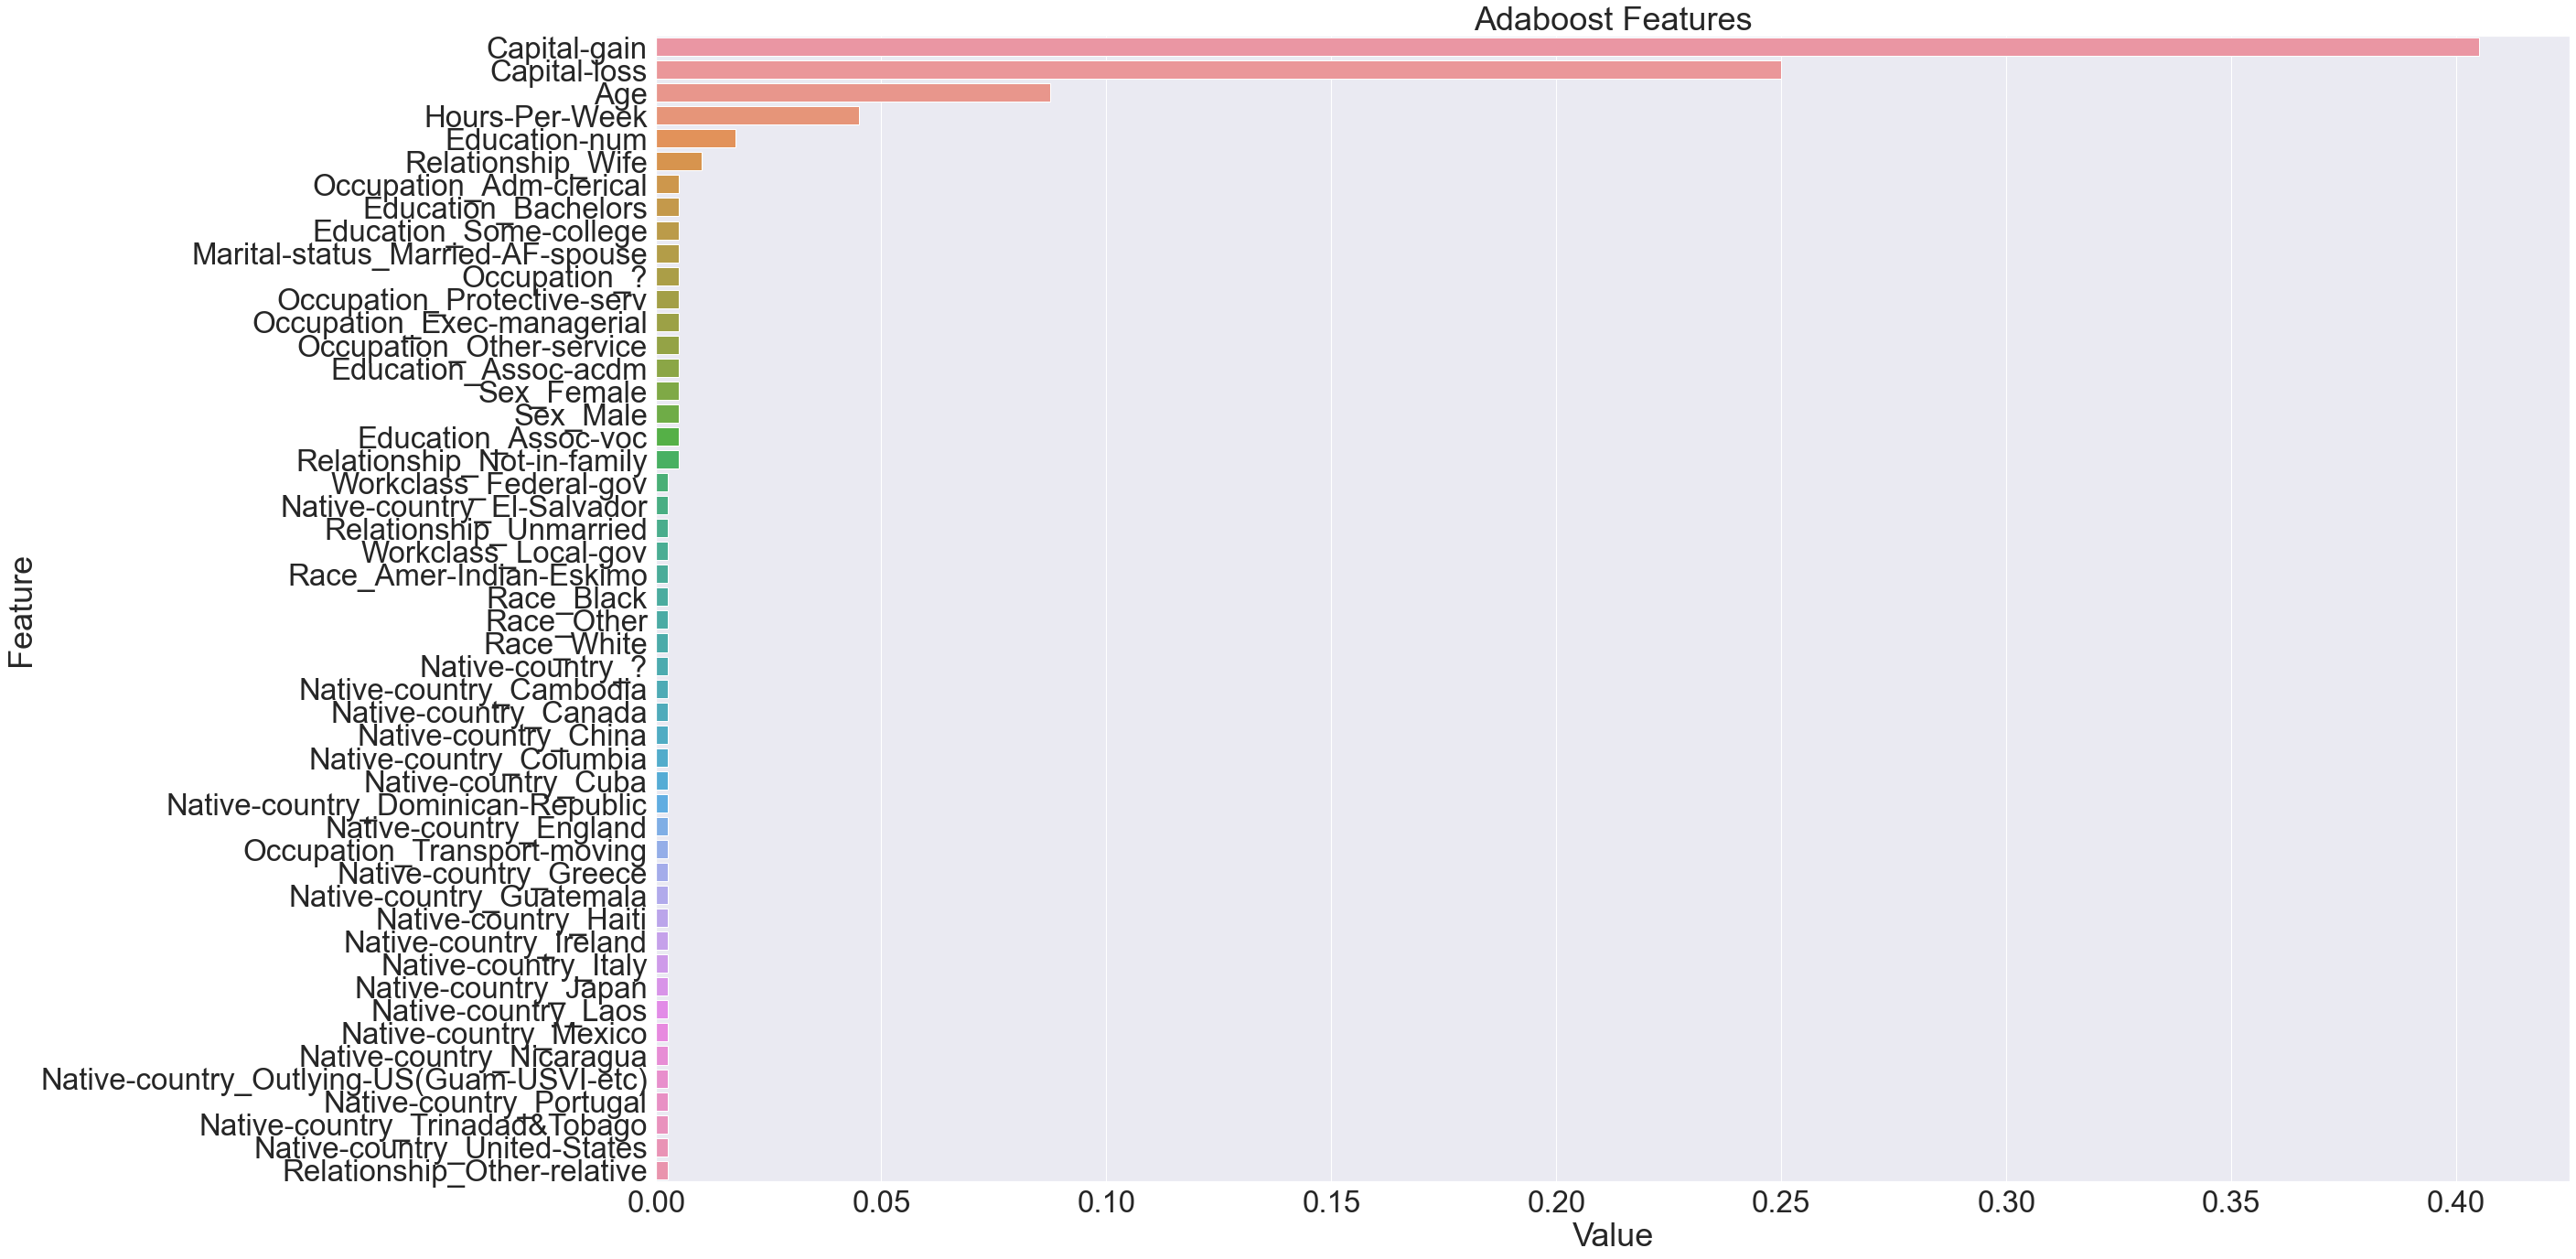

In [94]:
# e) Identify the top 5 features. Feel free to print a list OR to make a plot.

import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame({'Value':best_model.feature_importances_,'Feature':X_train.columns})
plt.figure(figsize=(40, 20))
sns.set(font_scale = 3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:50])
plt.title('Adaboost Features')
plt.tight_layout()
plt.show()

# The top 5 features are Capital-gain, capital-loss,age,hours-per-week,education-num

In [96]:
#f) Using the model from part B, predict for the train data. 
y_pred_adaboost_Grid_train = best_model.predict(X_train)
y_pred_proba_adaboost_Grid_train=best_model.predict_proba(X_train)

In [97]:
# Build the confusion matrix
confusion_matrix(y_train, y_pred_adaboost_Grid_train)

array([[16276,  1008],
       [ 1903,  3605]])

In [98]:
# Build the classification report
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_adaboost_Grid_train))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17284
           1       0.78      0.65      0.71      5508

    accuracy                           0.87     22792
   macro avg       0.84      0.80      0.82     22792
weighted avg       0.87      0.87      0.87     22792



In [99]:
# Calculate the roc_auc_score for this model on training data.
roc_auc_score(y_train, y_pred_proba_adaboost_Grid_train[:,1])

0.9305267321084966

No, the result after the grid search shows does not a sign of overfitting.
The weighted avg accuracy for training is 0.87 while yhe weighted avg accuracy for testing is also 0.87. The gap is very small, it does not show a trend/sign of overfitting since we see a tiny little drop after apply model on testing dataset. 

The AUC score on training 0.9305 while on testing is 0.9277, This drive the same result that it does not shows a sign of overfitting.


#### 4. Gradient Boosting Classifier - GridSearch:

In [100]:
#a) Use GradientBoostingClassifier along with the GridSearchCV tool. Run the GridSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
#create a dictionary of parameters 
param_grid = {'n_estimators':[100,200,300,400],
'learning_rate':[0.2,0.4,0.6,0.8,1, 1.2],
'max_depth':[1, 2]}

# create GBM model 
GBM_obj=GradientBoostingClassifier()

# Create gridsearch object with various combinations of parameters
GBM_Grid = GridSearchCV(GBM_obj, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)
# Fit the GridSearch
GBM_Grid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  8.0min finished
/Users/yangxiang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [103]:
# b) Use the best estimator from GridSearchCV to predict on test data.
# Identify the best performing model:
GBM_Grid.best_params_

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 400}

In [104]:
best_model_GBM=GBM_Grid.best_estimator_

In [105]:
# Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

y_pred_GBM_Grid = best_model_GBM.predict(X_test)
y_pred_proba_GBM_Grid=best_model_GBM.predict_proba(X_test)

In [106]:
# c) Calculate the confusion matrix and classification report (both are in sklearn.metrics). 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_GBM_Grid)

array([[7022,  414],
       [ 794, 1539]])

In [107]:
# Build the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_GBM_Grid))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7436
           1       0.79      0.66      0.72      2333

    accuracy                           0.88      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.88      0.87      9769



In [108]:
# d) Calculate the roc_auc_score for this model.
roc_auc_score(y_test, y_pred_proba_GBM_Grid[:,1])

0.9298966554893225

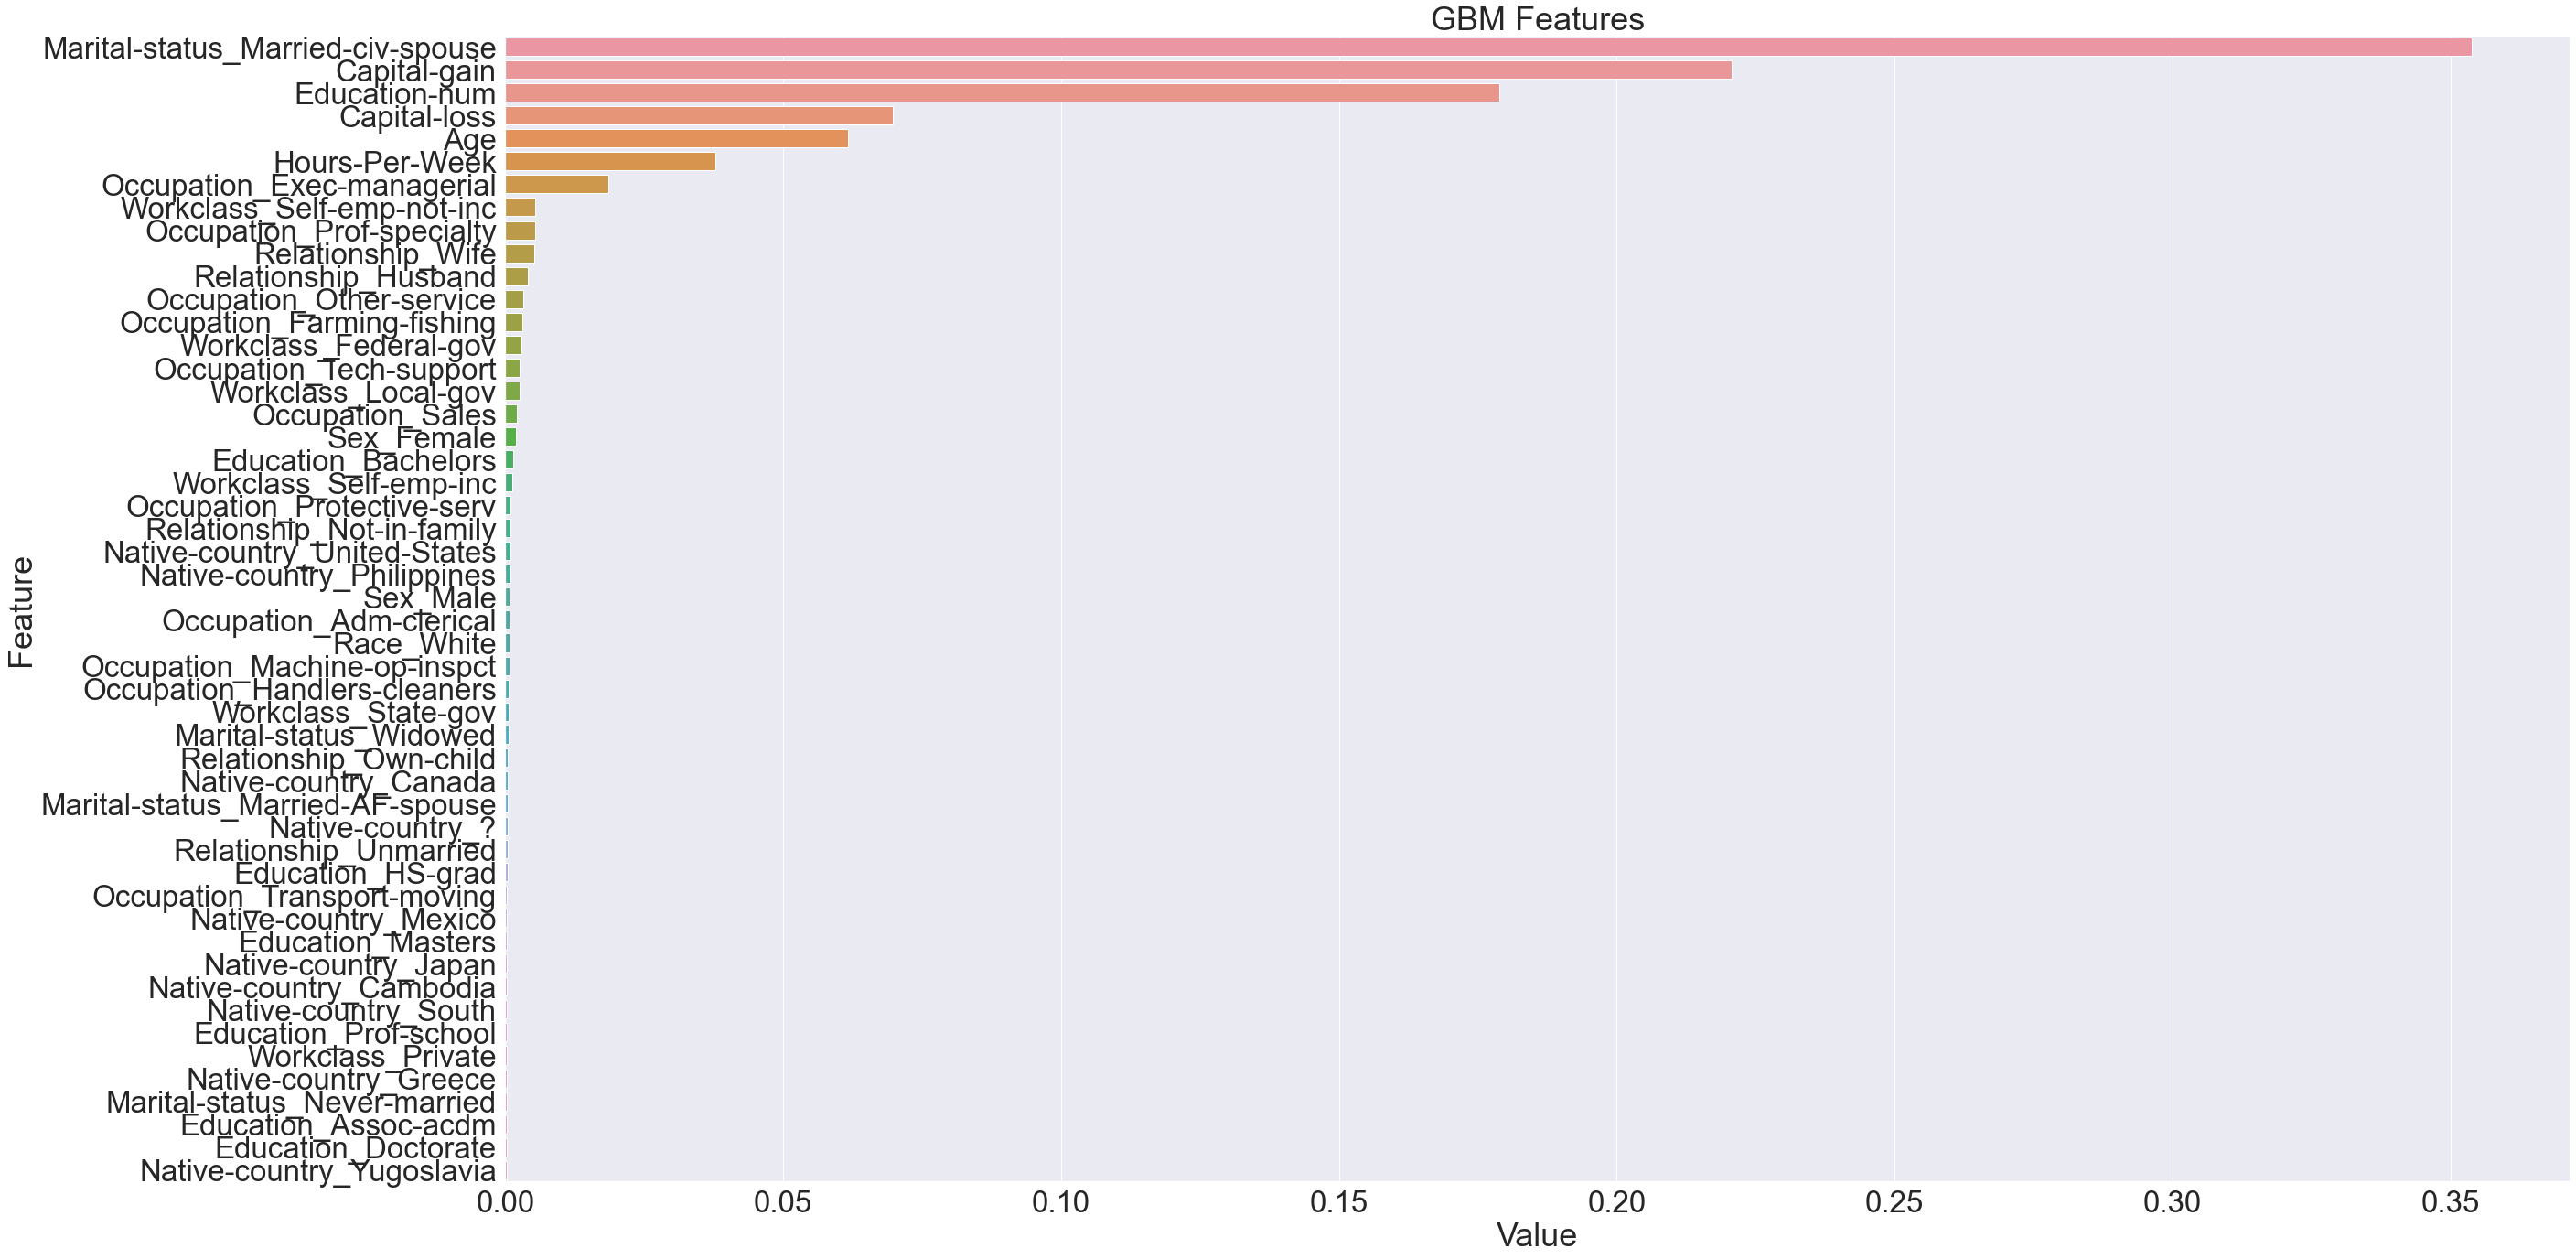

In [109]:
# e) Identify the top 5 features. Feel free to print a list OR to make a plot.

import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame({'Value':best_model_GBM.feature_importances_,'Feature':X_train.columns})
plt.figure(figsize=(40, 20))
sns.set(font_scale = 3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:50])
plt.title('GBM Features')
plt.tight_layout()
plt.show()

# The top 5 features are Marital-status_married-civ-spouse, Capital-gain, Eucation-num, Capital-loss, Age)

In [110]:
#f) Using the model from part B, predict for the train data. 
y_pred_GBM_Grid_train = best_model_GBM.predict(X_train)
y_pred_proba_GBM_Grid_train=best_model_GBM.predict_proba(X_train)

In [111]:
# Build the confusion matrix
confusion_matrix(y_train, y_pred_GBM_Grid_train)

array([[16365,   919],
       [ 1837,  3671]])

In [112]:
# Build the classification report
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_GBM_Grid_train))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     17284
           1       0.80      0.67      0.73      5508

    accuracy                           0.88     22792
   macro avg       0.85      0.81      0.82     22792
weighted avg       0.88      0.88      0.88     22792



In [113]:
# Calculate the roc_auc_score for this model on training data.
roc_auc_score(y_train, y_pred_proba_GBM_Grid_train[:,1])

0.9366870243816109

No, the result after the grid search shows does not a sign of overfitting.
The weighted avg accuracy for training is 0.88 while yhe weighted avg accuracy for testing is 0.87. The gap is very small, it does not show a trend/sign of overfitting since we see a tiny little drop after apply model on testing dataset. 

The AUC score on training 0.936687 while on testing is 0.92989, This drive the same result that it does not shows a sign of overfitting.


#### 5. XGBoost - RandomizedSearchCV

In [24]:
#a) Use XGBClassifier along with the RandomizedSearchCV tool. Run the RandomizedSearchCV 

# RandomizedSearchCV:In contrast to GridSearchCV, not all parameter values are tried out, 
#but rather a fixed number of parameter settings is sampled from the specified distributions. 

#The number of parameter settings that are tried is given by n_iter.
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
#create a dictionary of parameters 
param_grid = {'n_estimators':list(range(100,1050,50)),
'learning_rate': [x * 0.1 for x in range(1, 17)],
'max_depth':[1, 2],
'gamma':[x * 0.25 for x in range(0, 21)]}

# create GBM model 
XGB_obj=XGBClassifier()

# Create gridsearch object with various combinations of parameters
XGB_RandomizedSearch = RandomizedSearchCV(XGB_obj, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)
# Fit the GridSearch
XGB_RandomizedSearch.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.6min finished
/Users/yangxiang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangxiang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                                          0.30000000000000004,
                                                          0.4, 0.5,
                                 

In [25]:
# b) Use the best estimator from RandomizedSearch to predict on test data.
# Identify the best performing model:
XGB_RandomizedSearch.best_params_

{'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.8, 'gamma': 0.25}

In [26]:
best_model_XGB=XGB_RandomizedSearch.best_estimator_

In [27]:
# Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

y_pred_XGB_RandomizedSearch = best_model_XGB.predict(X_test)
y_pred_proba_XGB_RandomizedSearch=best_model_XGB.predict_proba(X_test)

In [28]:
# c) Calculate the confusion matrix and classification report (both are in sklearn.metrics). 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_XGB_RandomizedSearch)

array([[6996,  440],
       [ 779, 1554]])

In [29]:
# Build the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_XGB_RandomizedSearch))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7436
           1       0.78      0.67      0.72      2333

    accuracy                           0.88      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.88      0.87      9769



In [31]:
# d) Calculate the roc_auc_score for this model.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_proba_XGB_RandomizedSearch[:,1])

0.9296328239006864

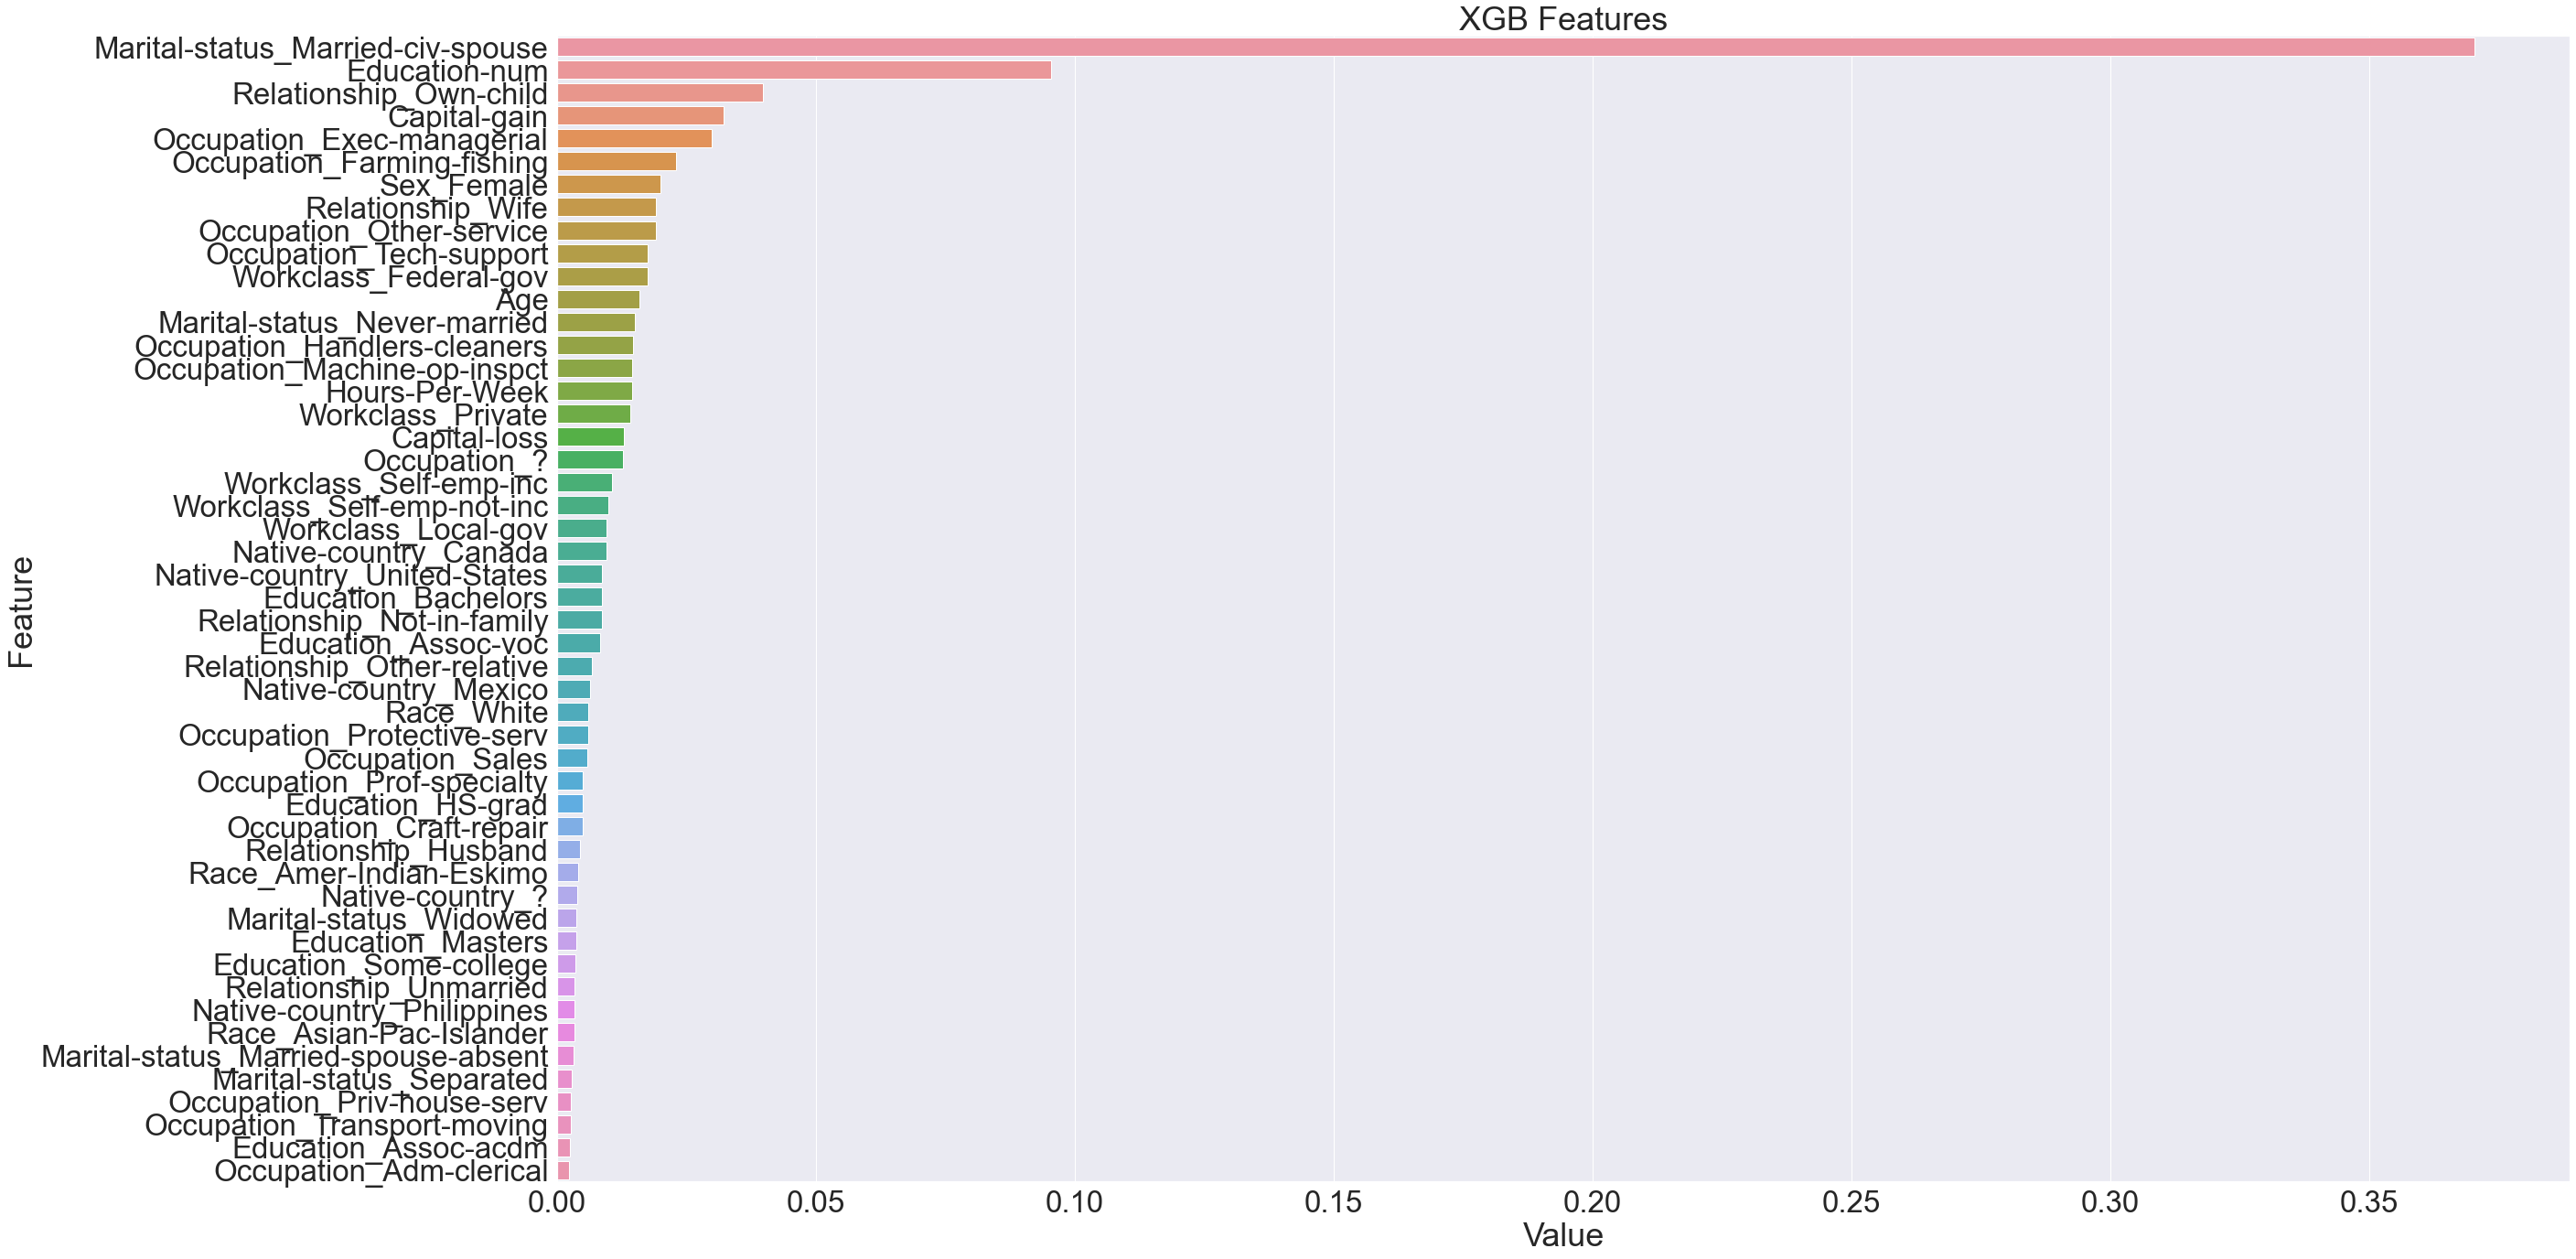

In [34]:
# e) Identify the top 5 features. Feel free to print a list OR to make a plot.

import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame({'Value':best_model_XGB.feature_importances_,'Feature':X_train.columns})
plt.figure(figsize=(40, 20))
sns.set(font_scale = 3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:50])
plt.title('XGB Features')
plt.tight_layout()
plt.show()

# The top 5 features are Marital-status_married-civ-spouse,Eucation-num,Relationship Own-Child,Capital-gain,Occupation Exec-managerial

In [35]:
#f) Using the model from part B, predict for the train data. 
y_pred_XGB_RandomizedSearch_train = best_model_XGB.predict(X_train)
y_pred_proba_XGB_RandomizedSearch_train=best_model_XGB.predict_proba(X_train)

In [36]:
# Build the confusion matrix
confusion_matrix(y_train, y_pred_XGB_RandomizedSearch_train)

array([[16357,   927],
       [ 1750,  3758]])

In [37]:
# Build the classification report
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_XGB_RandomizedSearch_train))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     17284
           1       0.80      0.68      0.74      5508

    accuracy                           0.88     22792
   macro avg       0.85      0.81      0.83     22792
weighted avg       0.88      0.88      0.88     22792



In [38]:
# Calculate the roc_auc_score for this model on training data.
roc_auc_score(y_train, y_pred_proba_XGB_RandomizedSearch_train[:,1])

0.9392658142825474

No, the result after the grid search shows does not a sign of overfitting.
The weighted avg accuracy for training is 0.88 while yhe weighted avg accuracy for testing is 0.87. The gap is very small, it does not show a trend/sign of overfitting since we see a tiny little drop after apply model on testing dataset. 

The AUC score on training 0.939265 while on testing is 0.929632, This drive the same result that it does not shows a sign of overfitting.

#### 6. Moving into Conceptual Problems:

###### a) What does the alpha parameter represent in AdaBoost? Please refer to chapter 7 of the Hands-On ML book if you are struggling.
alpha is the The predictor’s weight. It equal learning rate + log((1-rj)/rj). rj is the Weighted error rate of the jth predictor.

The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.


###### b) In AdaBoost explain how the final predicted class is determined. Be sure to reference the alpha term in your explanation.
To build an AdaBoost classifier, a first base classifier is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.

Once all predictors are trained, the ensemble makes predictions very much like bag‐ ging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.
To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights αj. The predicted class is the one that receives the majority of weighted votes 

###### c) In Gradient Boosting, what is the role of the max_depth parameter? Why is it important to tune on this parameter?
max_depth is The maximum depth of a tree. It should be tuned using CV.

It is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample. Setying a good max_depth will prevent model from overfitting(Catching too much noise from training data)

###### d) In Part (e) of Steps 2-5 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if this predictor makes sense given what you are attempting to predict. (Note: If you don't have any predictors showing up across all 3 predictors, explain one that shows up in 2 of them).

Yes,Eucation-num and Capital-gain show up in all the model top 5 features. 
These 2 predictor makes sense because for prople receive more education tend to earn more compare to those who receive less eduction, also Capital-gain is another way of say asset, since people with higer salary tend to gain more asset(Capital-gain), this feature is also strongly positive correlated. We are here to predit the salay is over or under 50K.So these two feature make prefect sense.

###### e) From the models run in steps 2-5, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyperparameters found from your grid search.
XGBoost perfrom the best in my model. with weighted precision avg 0.87 and weighted recall avg 0.88. Those are the highest among all even if GBM and Adaboost also preform very well in this project.
optimal hyperparameters:{'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.8, 'gamma': 0.25}





###### f) For your best performing model, plot out a ROC curve using your test data. Feel free to use sklearn, matplotlib or any other method in python. Describe what the x-axis & y-axis of the ROC curve tell us about a classifier.




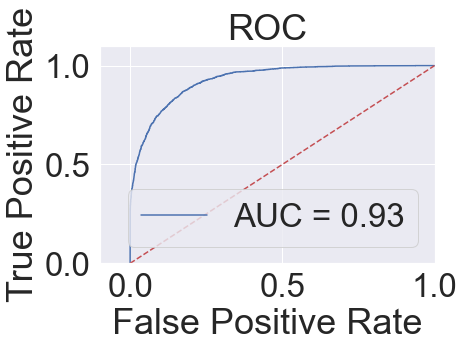

In [42]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = y_pred_proba_XGB_RandomizedSearch
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

* y-axis is the True Positive Rate=TP/(TP+FN), tells us what proportion of >50K samples were correctly classified.

* x-axis is the False Positive Rate=FP/(FP+TN), tells us what proportion of <=50K samples were incorrectly classified

